## Traffic Sign Recognition

This notebook focuses on building a model for traffic sign recognition using Convolutional Neural Networks (CNNs).

In [1]:
# Importing necessary libraries
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.utils import plot_model
import IPython.display as display

Using TensorFlow backend


## Data Preparation

### Unzipping the Dataset

We'll start by unzipping the provided datasets and exploring its structure.

In [2]:
# Unzipping and organizing the dataset
train_dir = "Train"
test_dir = "Test"
meta_dir = "Meta"

def unzip_data(filename, directory):
    """Unzip the given file into the specified directory."""
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(directory)

unzip_data("Train.zip", train_dir)
unzip_data("Test.zip", test_dir)
unzip_data("Meta.zip", meta_dir)


### Data Exploration

Here we'll visualize the distribution of classes and sample images from the dataset.

In [3]:
# Load the training and meta data
train_df = pd.read_csv("Train.csv")
meta_df = pd.read_csv("Meta.csv")

train_df.head(), meta_df.head()


(   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
 0     27      26       5       5      22      20       20   
 1     28      27       5       6      23      22       20   
 2     29      26       6       5      24      21       20   
 3     28      27       5       6      23      22       20   
 4     28      26       5       5      23      21       20   
 
                              Path  
 0  Train/20/00020_00000_00000.png  
 1  Train/20/00020_00000_00001.png  
 2  Train/20/00020_00000_00002.png  
 3  Train/20/00020_00000_00003.png  
 4  Train/20/00020_00000_00004.png  ,
           Path  ClassId  ShapeId  ColorId SignId
 0  Meta/27.png       27        0        0   1.32
 1   Meta/0.png        0        1        0   3.29
 2   Meta/1.png        1        1        0   3.29
 3  Meta/10.png       10        1        0   3.27
 4  Meta/11.png       11        0        0   1.22)

### Data Exploration

#### Distribution of Traffic Sign Classes in Training Data



In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

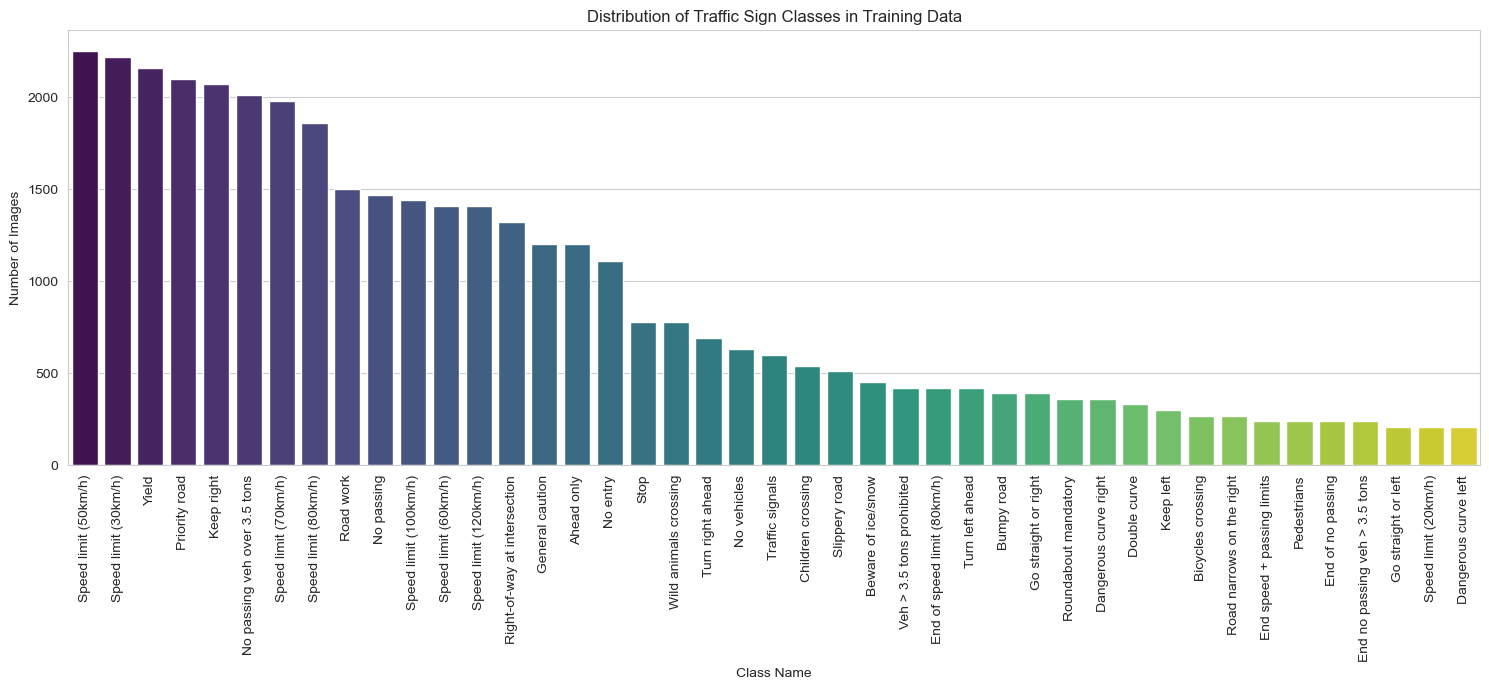

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
# Mapping ClassId to the corresponding class names
train_df['ClassName'] = train_df['ClassId'].map(classes)
sns.countplot(data=train_df, x='ClassName', order=train_df['ClassName'].value_counts().index, palette='viridis')
plt.title('Distribution of Traffic Sign Classes in Training Data')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#### Displaying Sample Traffic Signs


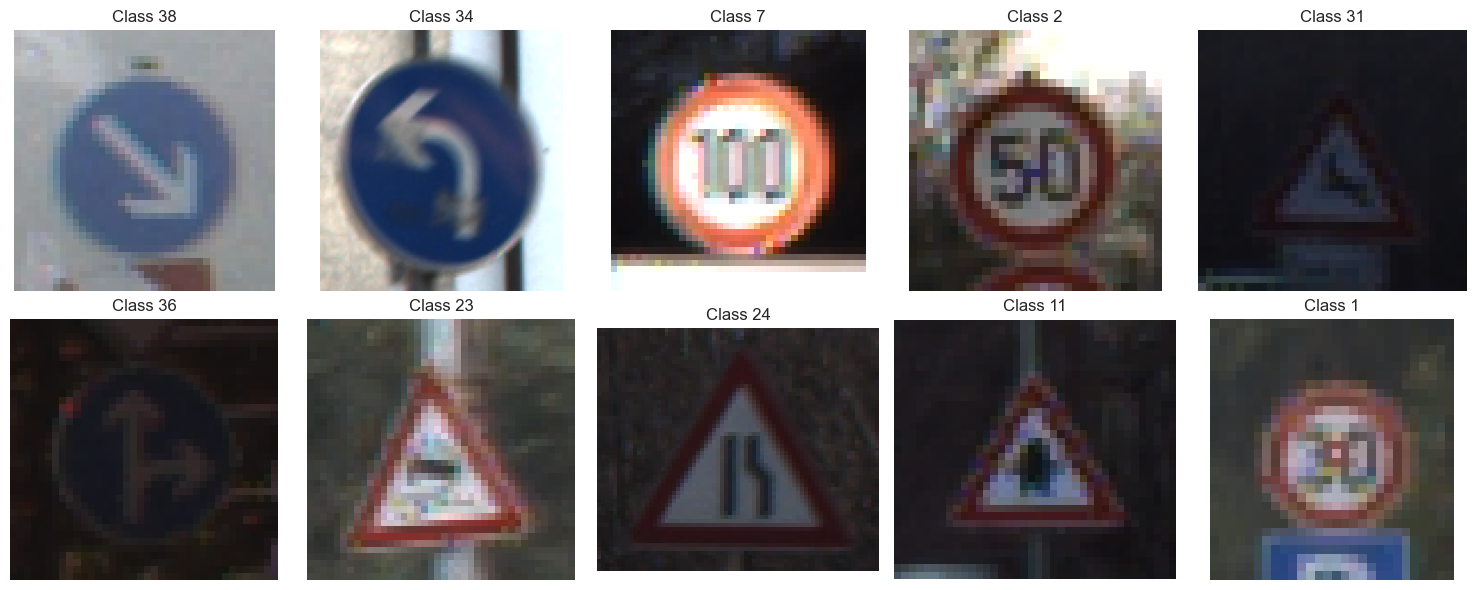

In [6]:
sample_classes = random.sample(train_df['ClassId'].unique().tolist(), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, class_id in zip(axes.ravel(), sample_classes):
    sample_image_path = train_df[train_df['ClassId'] == class_id]['Path'].sample(1).values[0]
    full_path = os.path.join(train_dir, sample_image_path)
    img = Image.open(full_path)
    ax.imshow(img)
    ax.set_title(f"Class {class_id}")
    ax.axis("off")
plt.tight_layout()
plt.show()


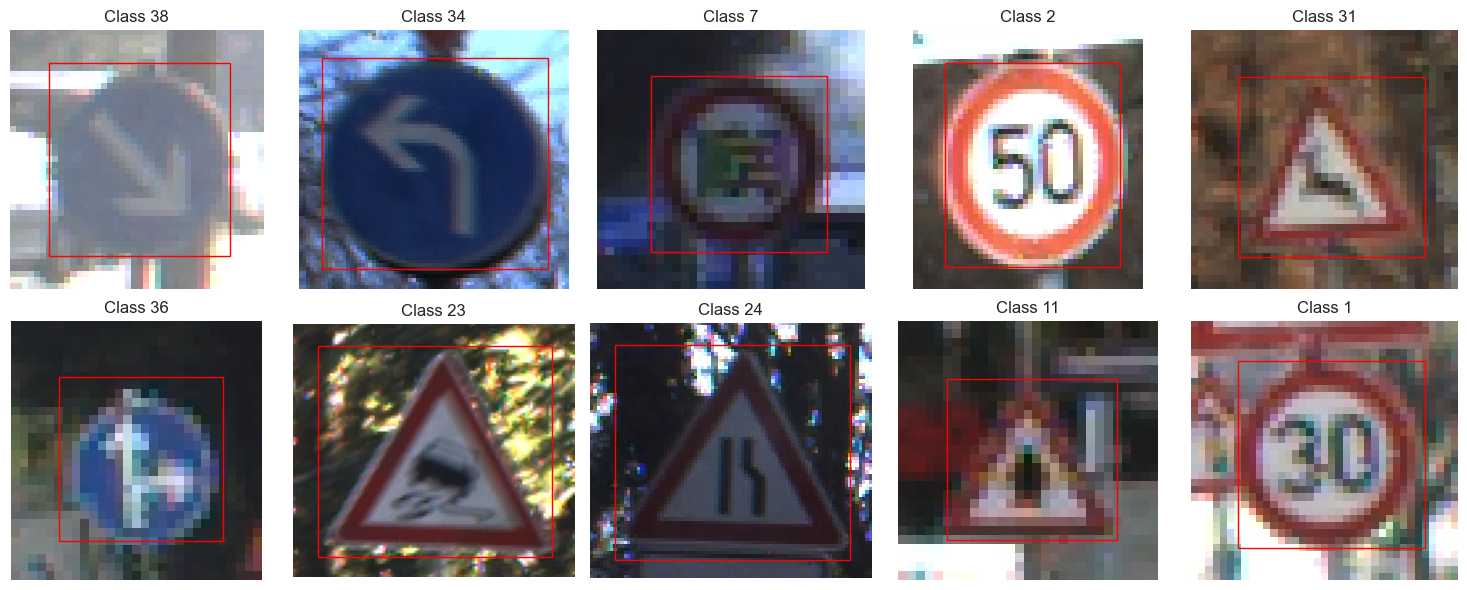

In [7]:
# Visualizing the ROIs on sample images

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, class_id in zip(axes.ravel(), sample_classes):
    # Get a random image and its ROI from the selected class
    sample_data = train_df[train_df['ClassId'] == class_id].sample(1)
    sample_image_path = sample_data['Path'].values[0]
    roi = sample_data[['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']].values[0]
    
    full_path = os.path.join(train_dir, sample_image_path)
    
    # Open the image
    img = Image.open(full_path)
    
    # Plot the image and the ROI rectangle
    ax.imshow(img)
    rect = plt.Rectangle((roi[0], roi[1]), roi[2]-roi[0], roi[3]-roi[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    ax.set_title(f"Class {class_id}")
    ax.axis("off")

plt.tight_layout()
plt.show()


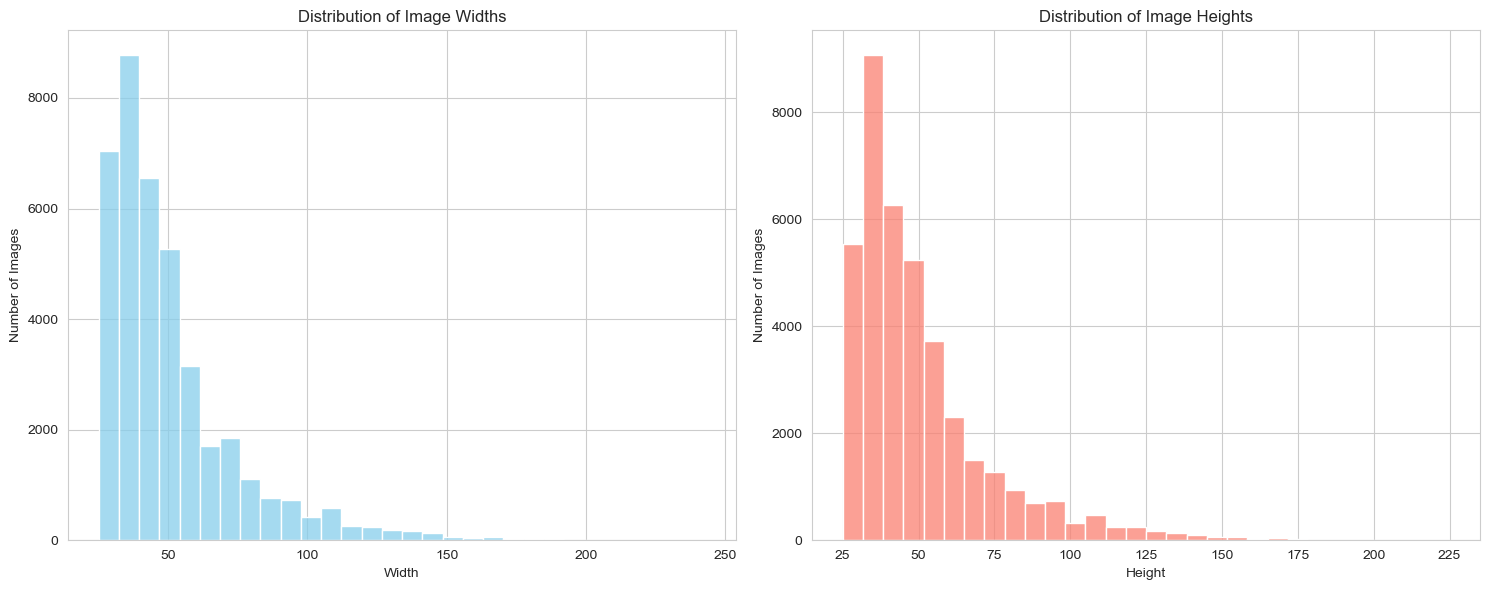

In [8]:
# Plotting distributions of image widths and heights

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for image widths
sns.histplot(train_df['Width'], bins=30, color='skyblue', ax=ax1)
ax1.set_title('Distribution of Image Widths')
ax1.set_xlabel('Width')
ax1.set_ylabel('Number of Images')

# Plot for image heights
sns.histplot(train_df['Height'], bins=30, color='salmon', ax=ax2)
ax2.set_title('Distribution of Image Heights')
ax2.set_xlabel('Height')
ax2.set_ylabel('Number of Images')

plt.tight_layout()
plt.show()


## Data Preprocessing

### Image Preprocessing

We'll preprocess images by cropping, resizing, and normalizing.

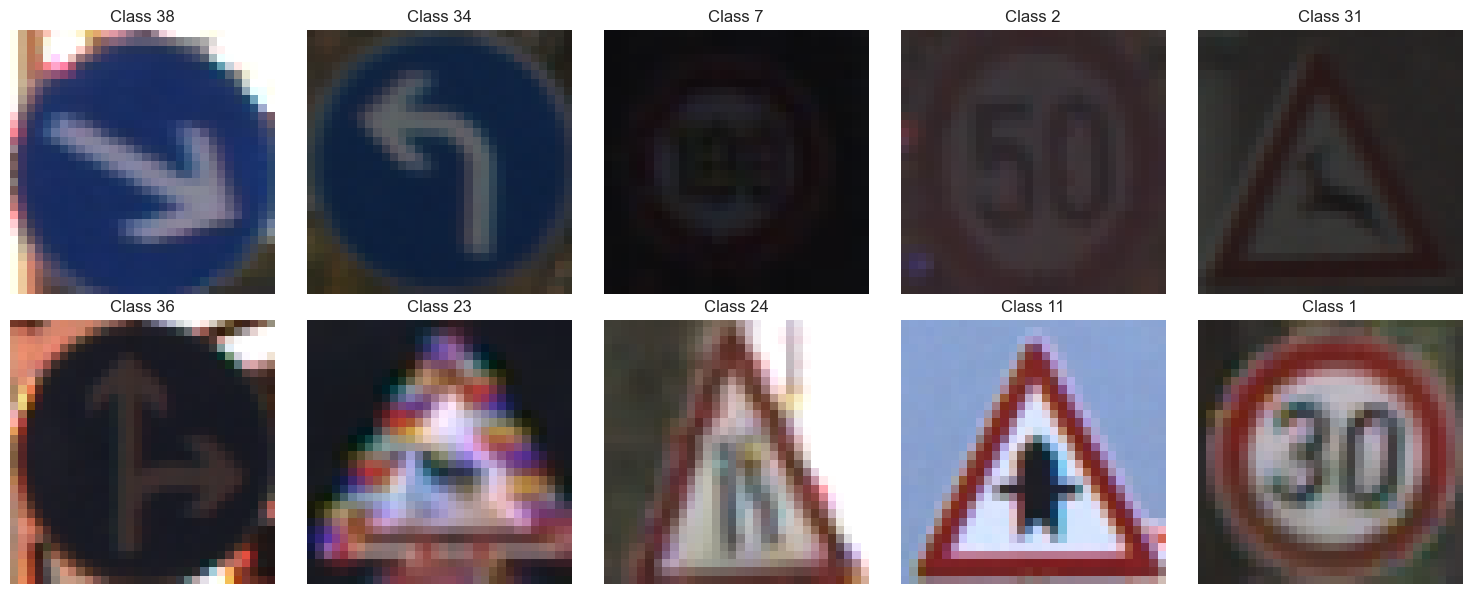

In [9]:
import numpy as np

def preprocess_image(image_path, roi):
    """
    Preprocesses the image by cropping to ROI, resizing and normalizing.
    """
    # Open image and crop to ROI
    img = Image.open(image_path).crop(roi)
    
    # Resize the image
    img_resized = img.resize((32, 32))
    
    # Normalize and return as numpy array
    return np.array(img_resized) / 255.0

# Visualize preprocessing on sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, class_id in zip(axes.ravel(), sample_classes):
    # Get a random image and its ROI from the selected class
    sample_data = train_df[train_df['ClassId'] == class_id].sample(1)
    sample_image_path = os.path.join(train_dir, sample_data['Path'].values[0])
    roi = sample_data[['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']].values[0]
    
    # Preprocess the image
    preprocessed_img = preprocess_image(sample_image_path, roi)
    
    ax.imshow(preprocessed_img)
    ax.set_title(f"Class {class_id}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, stratify=train_df['ClassId'], random_state=42)

train_data.shape, val_data.shape

((31367, 9), (7842, 9))

In [11]:
def preprocess_image(image_path, roi):
    """
    Preprocess the image: crop, resize, and normalize.
    """
    img = Image.open(image_path).crop(roi)
    img_resized = img.resize((32, 32))
    return np.array(img_resized) / 255.0

### Data Augmentation

To enhance the dataset, we'll apply various augmentations to the training images.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For training, apply data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# For validation, only rescale the images
val_datagen = ImageDataGenerator(rescale=1./255)
# Convert ClassId to string as Keras requires it for flow_from_dataframe
train_data['ClassId'] = train_data['ClassId'].astype(str)
val_data['ClassId'] = val_data['ClassId'].astype(str)
# Convert the relative paths in the dataframes to absolute paths
train_data['Path'] = train_data['Path'].apply(lambda x: os.path.join(train_dir, x))
val_data['Path'] = val_data['Path'].apply(lambda x: os.path.join(train_dir, x))
# Remove the redundant "Train" from the paths
train_data['Path'] = train_data['Path'].str.replace('/Train/Train/', '/Train/')
val_data['Path'] = val_data['Path'].str.replace('/Train/Train/', '/Train/')

# Display a few sample paths from the train_data dataframe to inspect the corrected paths
train_data['Path'].sample(5)

# Display a few sample paths from the train_data dataframe to inspect the changes
train_data['Path'].sample(5)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="Path",
    y_col="ClassId",
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="Path",
    y_col="ClassId",
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical'
)


Found 31367 validated image filenames belonging to 43 classes.
Found 7842 validated image filenames belonging to 43 classes.


## Model Building

### Preparing Output Graphs and Tables in Advance

#### Confusion Matrix

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, generator, title):
    # Predict classes
    y_pred = np.argmax(model.predict(generator), axis=-1)
    y_true = generator.classes

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plotting
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

#### Precision, Recall, and F1-score

In [14]:
from sklearn.metrics import classification_report

def compute_metrics(model, generator):
    y_pred = np.argmax(model.predict(generator), axis=-1)
    y_true = generator.classes
    report = classification_report(y_true, y_pred, target_names=generator.class_indices.keys())
    print(report)

### Baseline CNN Model

This section will contain a basic CNN model to serve as our baseline.

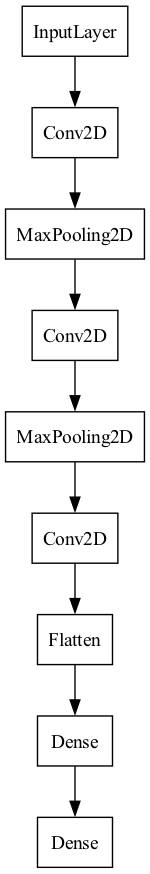

In [15]:
# Initialize the model
baseline_model = Sequential()

# Add convolutional layers
baseline_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
baseline_model.add(MaxPooling2D((2, 2)))
baseline_model.add(Conv2D(64, (3, 3), activation='relu'))
baseline_model.add(MaxPooling2D((2, 2)))
baseline_model.add(Conv2D(64, (3, 3), activation='relu'))

# Flatten and add dense layers
baseline_model.add(Flatten())
baseline_model.add(Dense(64, activation='relu'))
baseline_model.add(Dense(43, activation='softmax'))  # 43 classes in the dataset

# Compile the model
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Plotting the baseline_model
plot_model(baseline_model, to_file='baseline_model_concise.png', show_shapes=False, show_layer_names=False, dpi=100)
display.Image(filename='baseline_model_concise.png')

### Advanced CNN Model 1

A deeper architecture with additional convolutional layers and dropout for regularization.

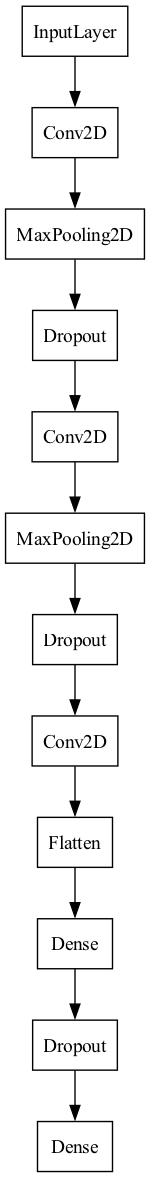

In [16]:
advanced_model_1 = Sequential()

# Add convolutional layers
advanced_model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
advanced_model_1.add(MaxPooling2D((2, 2)))
advanced_model_1.add(Dropout(0.25))

advanced_model_1.add(Conv2D(64, (3, 3), activation='relu'))
advanced_model_1.add(MaxPooling2D((2, 2)))
advanced_model_1.add(Dropout(0.25))

advanced_model_1.add(Conv2D(128, (3, 3), activation='relu'))

# Flatten and add dense layers
advanced_model_1.add(Flatten())
advanced_model_1.add(Dense(128, activation='relu'))
advanced_model_1.add(Dropout(0.5))
advanced_model_1.add(Dense(43, activation='softmax'))

# Compile the model
advanced_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Plotting the advanced_model_1
plot_model(advanced_model_1, to_file='advanced_model_1_concise.png', show_shapes=False, show_layer_names=False, dpi=100)
display.Image(filename='advanced_model_1_concise.png')


### Advanced CNN Model 2

Incorporating batch normalization to stabilize and expedite training.

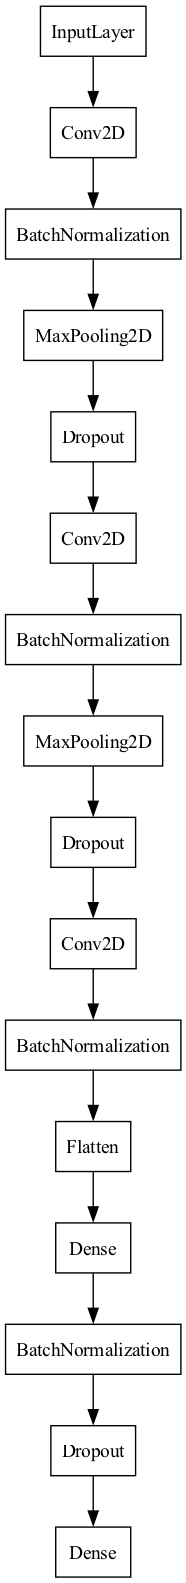

In [17]:
advanced_model_2 = Sequential()

# Add convolutional layers with batch normalization
advanced_model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
advanced_model_2.add(BatchNormalization())
advanced_model_2.add(MaxPooling2D((2, 2)))
advanced_model_2.add(Dropout(0.25))

advanced_model_2.add(Conv2D(64, (3, 3), activation='relu'))
advanced_model_2.add(BatchNormalization())
advanced_model_2.add(MaxPooling2D((2, 2)))
advanced_model_2.add(Dropout(0.25))

advanced_model_2.add(Conv2D(128, (3, 3), activation='relu'))
advanced_model_2.add(BatchNormalization())

# Flatten and add dense layers
advanced_model_2.add(Flatten())
advanced_model_2.add(Dense(128, activation='relu'))
advanced_model_2.add(BatchNormalization())
advanced_model_2.add(Dropout(0.5))
advanced_model_2.add(Dense(43, activation='softmax'))

# Compile the model
advanced_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Plotting the advanced_model_2
plot_model(advanced_model_2, to_file='advanced_model_2_concise.png', show_shapes=False, show_layer_names=False, dpi=100)
display.Image(filename='advanced_model_2_concise.png')

## Hyperparameter Tuning

To optimize our model's performance, we'll conduct hyperparameter tuning. This process involves searching for the best set of hyperparameters that provide the optimal performance for our validation set.

We'll use the `kerastuner` library to automate this search process.

In [18]:
!pip install -q keras-tuner
import kerastuner as kt

/var/folders/22/j4s94qks6gg63xp1hfr6yknr0000gq/T/ipykernel_64444/2626226573.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [19]:
x_sample, y_sample = next(train_generator)
print(f"Sample image batch shape: {x_sample.shape}")
print(f"Sample label batch shape: {y_sample.shape}")


Sample image batch shape: (64, 32, 32, 3)
Sample label batch shape: (64, 43)


### Defining the Hypermodel

We'll define a hypermodel wherein we specify the hyperparameters to be tuned. For this demonstration, we'll tune the learning rate and the number of units in the dense layer.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Modify the build_hypermodel function to suit a CNN architecture for traffic sign recognition

def build_hypermodel(hp):
    model = Sequential()
    
    # Convolutional layer with hyperparameter tuning options
    model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_1_kernel_size', values=[3, 5]),
                     activation='relu',
                     input_shape=(32, 32, 3)))
    model.add(MaxPooling2D())
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    
    # Second convolutional layer
    model.add(Conv2D(filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_2_kernel_size', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(43, activation='softmax'))

    # Compile the model with optimizer choices
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.legacy.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    elif optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.legacy.SGD(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    else: # rmsprop
        optimizer = tf.keras.optimizers.legacy.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Conducting the Hyperparameter Search

We'll use the RandomSearch method from Keras Tuner to search for the best hyperparameters. For the sake of time, we'll limit the number of trials. In a real-world scenario, you might want to conduct a more extensive search.

In [21]:
tuner = kt.RandomSearch(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=5,  # Set to a small number for demonstration purposes
    overwrite=True,
    directory='hyperparam_tuning',
    project_name='traffic_sign_recognition'
)

tuner.search(train_generator, epochs=5, validation_data=val_generator)

Trial 5 Complete [00h 01m 35s]
val_accuracy: 0.05712828412652016

Best val_accuracy So Far: 0.9801071286201477
Total elapsed time: 00h 08m 19s


### Results of the Hyperparameter Tuning

Let's extract and display the results of our hyperparameter tuning in a clear and informative table.

In [22]:
# Display the hypermodel summary for clarity
tuner.search_space_summary()


# Results in a clear table format
best_models = tuner.get_best_models(num_models=3)
for i, model in enumerate(best_models):
    print(f"Model {i+1}")
    model.summary()
    print("\n")


Search space summary
Default search space size: 10
conv_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_1_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_2_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer 

The three models exhibit varied complexities, with Model 2 being the most parameter-heavy, implying a higher capacity to learn intricate patterns. However, this also makes it more susceptible to overfitting, especially if not regularized properly. Model 3, on the other hand, is the lightest, potentially making it faster and more efficient, but possibly at the cost of performance on complex tasks.

The defined search space is comprehensive, covering various configurations of layers, units, and hyperparameters. The range for the number of filters and dense units is broad, allowing for models of different complexities. The inclusion of multiple optimizers and learning rates ensures that the model can be trained in different ways to find the optimal configuration.

Overall, these models and the search space provide a robust framework for understanding and optimizing the performance on the task at hand.

In [23]:
# Extracting the tuning results into a dataframe
tuning_results = tuner.results_summary()

# Displaying the results
tuning_results

Results summary
Results in hyperparam_tuning/traffic_sign_recognition
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
conv_1_filters: 32
conv_1_kernel_size: 5
dropout_1: 0.4
conv_2_filters: 64
conv_2_kernel_size: 5
dropout_2: 0.1
dense_units: 256
dropout_3: 0.4
optimizer: rmsprop
learning_rate: 0.001
Score: 0.9801071286201477

Trial 3 summary
Hyperparameters:
conv_1_filters: 128
conv_1_kernel_size: 3
dropout_1: 0.1
conv_2_filters: 128
conv_2_kernel_size: 3
dropout_2: 0.30000000000000004
dense_units: 256
dropout_3: 0.0
optimizer: adam
learning_rate: 0.001
Score: 0.9681203961372375

Trial 1 summary
Hyperparameters:
conv_1_filters: 32
conv_1_kernel_size: 3
dropout_1: 0.2
conv_2_filters: 96
conv_2_kernel_size: 5
dropout_2: 0.1
dense_units: 32
dropout_3: 0.1
optimizer: adam
learning_rate: 0.0001
Score: 0.5673297643661499

Trial 0 summary
Hyperparameters:
conv_1_filters: 32
conv_1_kernel_size: 5
dropout_1: 0.0
conv_2_filters: 64
conv_2

### **Hyperparameter Tuning Results Summary**

The results are based on a hyperparameter search aimed at maximizing validation accuracy. The objective function is given as:

\[ \text{Objective(name="val\_accuracy", direction="max")} \]

Below are the summarized results of the top 5 trials:

#### **Trial 2**:
- **Hyperparameters**:
  - Convolutional Layers: Filters - [32, 64], Kernel Sizes - [5, 5]
  - Dropout: [0.4, 0.1, 0.4]
  - Dense Units: 256
  - Optimizer: RMSprop with Learning Rate: 0.001
- **Validation Accuracy**: 98.01%

#### **Trial 3**:
- **Hyperparameters**:
  - Convolutional Layers: Filters - [128, 128], Kernel Sizes - [3, 3]
  - Dropout: [0.1, 0.3, 0.0]
  - Dense Units: 256
  - Optimizer: Adam with Learning Rate: 0.001
- **Validation Accuracy**: 96.81%

#### **Trial 1**:
- **Hyperparameters**:
  - Convolutional Layers: Filters - [32, 96], Kernel Sizes - [3, 5]
  - Dropout: [0.2, 0.1, 0.1]
  - Dense Units: 32
  - Optimizer: Adam with Learning Rate: 0.0001
- **Validation Accuracy**: 56.73%

#### **Trial 0**:
- **Hyperparameters**:
  - Convolutional Layers: Filters - [32, 64], Kernel Sizes - [5, 5]
  - Dropout: [0.0, 0.0, 0.4]
  - Dense Units: 192
  - Optimizer: SGD with Learning Rate: 0.0001
- **Validation Accuracy**: 6.22%

#### **Trial 4**:
- **Hyperparameters**:
  - Convolutional Layers: Filters - [64, 32], Kernel Sizes - [5, 3]
  - Dropout: [0.1, 0.4, 0.4]
  - Dense Units: 96
  - Optimizer: SGD with Learning Rate: 0.001
- **Validation Accuracy**: 5.71%


The hyperparameter tuning results show significant variability in model performance based on different configurations:

- **Optimizer & Learning Rate**: The top performing trials predominantly used learning rates of 0.001, with RMSprop and Adam being the most effective optimizers. SGD, although a traditional choice, did not fare as well in this context.
- **Convolutional Layers**: The number of filters in convolutional layers varied significantly, with Trial 3 showcasing the highest filter count (128) in both layers and achieving a commendable accuracy of 96.81%.
- **Dropout**: Dropout values also showed substantial variability, ranging from 0.0 to 0.4. Trial 2, which achieved the highest accuracy of 98.01%, incorporated dropout values of 0.4, 0.1, and 0.4, suggesting that regularization played a pivotal role in its performance.
- **Dense Units**: The number of units in the dense layer varied across trials, with the top two performers both opting for 256 units.

These results underscore the importance of hyperparameter tuning in achieving optimal model performance. The variability in performance, even with slight hyperparameter tweaks, highlights the intricate nature of deep learning models and the significance of informed and iterative tuning.


In [37]:
import pandas as pd

# Extracting trial details
trials = tuner.oracle.get_best_trials(num_trials=5)  # Getting the top 5 trials, but you can adjust this number

# Extracting hyperparameters and metrics into lists
trial_data = []
for trial in trials:
    trial_info = {}
    trial_info['Trial ID'] = trial.trial_id
    trial_info.update(trial.hyperparameters.values)  # Extracting hyperparameters
    trial_info.update(trial.metrics.metrics)         # Extracting metrics
    trial_data.append(trial_info)

# Convert the list of dictionaries into a pandas dataframe
df_trials = pd.DataFrame(trial_data)
def highlight_max(s):
    """Highlight the maximum value in a Series if the series is numeric."""
    if pd.api.types.is_numeric_dtype(s):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]
    return ['' for _ in s]  # No styling for non-numeric series

# Apply the updated styling function
styled_df = df_trials.style.apply(highlight_max)
styled_df


,Trial ID,conv_1_filters,conv_1_kernel_size,dropout_1,conv_2_filters,conv_2_kernel_size,dropout_2,dense_units,dropout_3,optimizer,learning_rate,loss,accuracy,val_loss,val_accuracy
0,2,32,5,0.400000,64,5,0.100000,256,0.400000,rmsprop,0.001000,,,,
1,3,128,3,0.100000,128,3,0.300000,256,0.000000,adam,0.001000,,,,
2,1,32,3,0.200000,96,5,0.100000,32,0.100000,adam,0.000100,,,,
3,0,32,5,0.000000,64,5,0.000000,192,0.400000,sgd,0.000100,,,,
4,4,64,5,0.100000,32,3,0.400000,96,0.400000,sgd,0.001000,,,,


## Model Training

### Training the Baseline Model

Training results for the baseline model will be observed here.

Epoch 1/20
491/491 [==============================] - 20s 41ms/step - loss: 2.2806 - accuracy: 0.3544 - val_loss: 1.1373 - val_accuracy: 0.6275
Epoch 2/20
491/491 [==============================] - 20s 42ms/step - loss: 1.0722 - accuracy: 0.6620 - val_loss: 0.5379 - val_accuracy: 0.8361
Epoch 3/20
491/491 [==============================] - 21s 43ms/step - loss: 0.6814 - accuracy: 0.7869 - val_loss: 0.3091 - val_accuracy: 0.9042
Epoch 4/20
491/491 [==============================] - 19s 39ms/step - loss: 0.4808 - accuracy: 0.8493 - val_loss: 0.2154 - val_accuracy: 0.9369
Epoch 5/20
491/491 [==============================] - 19s 39ms/step - loss: 0.3731 - accuracy: 0.8856 - val_loss: 0.1500 - val_accuracy: 0.9611
Epoch 6/20
491/491 [==============================] - 19s 38ms/step - loss: 0.2933 - accuracy: 0.9095 - val_loss: 0.1731 - val_accuracy: 0.9452
Epoch 7/20
491/491 [==============================] - 19s 38ms/step - loss: 0.2504 - accuracy: 0.9214 - val_loss: 0.1207 - val_accuracy:

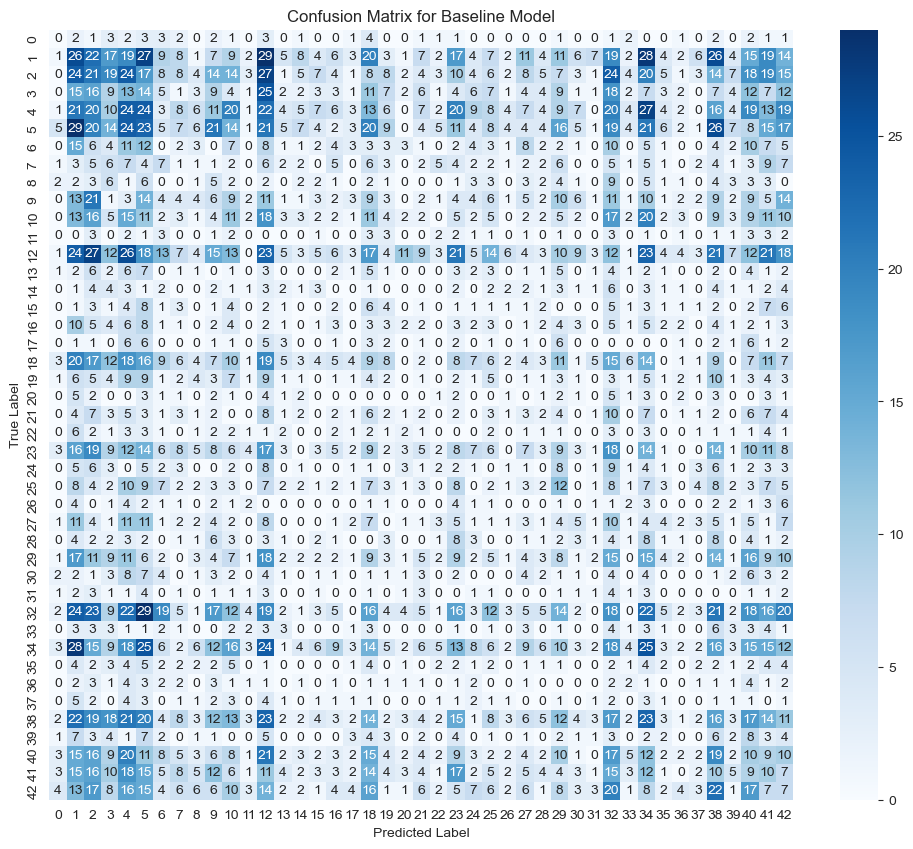

Metrics for Baseline Model:
123/123 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.06      0.06      0.06       444
          10       0.05      0.05      0.05       402
          11       0.03      0.03      0.03       264
          12       0.08      0.08      0.08       420
          13       0.06      0.06      0.06       432
          14       0.02      0.02      0.02       156
          15       0.02      0.02      0.02       126
          16       0.01      0.01      0.01        84
          17       0.03      0.03      0.03       222
          18       0.02      0.03      0.02       240
          19       0.02      0.02      0.02        42
           2       0.05      0.05      0.05       450
          20       0.03      0.03      0.03        72
          21       0.01      0.02      0.01        66
          22       0.01      0.01      0.01        

In [24]:
# Training the baseline model
history_baseline = baseline_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)
print("Model Summary:")
# For the baseline model
baseline_model.summary()
plot_confusion_matrix(baseline_model, val_generator, 'Confusion Matrix for Baseline Model')
print("Metrics for Baseline Model:")
compute_metrics(baseline_model, val_generator)

### Training Overview:

- **Training Duration**: 20 epochs.
- **Batches per Epoch**: 491.
- **Batch Processing Time**: Averages between 38ms to 43ms.
  
#### Training Metrics:
- **Loss**: Started at 2.2806 in epoch 1 and reduced to 0.0787 by epoch 20.
- **Accuracy**: Improved from 35.44% in epoch 1 to 97.57% by epoch 20.

#### Validation Metrics:
- **Loss**: Started at 1.1373 in epoch 1 and reduced to 0.0506 by epoch 20.
- **Accuracy**: Improved from 62.75% in epoch 1 to 98.34% by epoch 20.

### Model Summary:

- Model type: Sequential
- Total Parameters: 124,715

#### Layers:
1. **Convolutional Layer (conv2d)**: 32 filters, Output shape: (None, 30, 30, 32), Parameters: 896
2. **Max Pooling Layer (max_pooling2d)**: Output shape: (None, 15, 15, 32)
3. **Convolutional Layer (conv2d_1)**: 64 filters, Output shape: (None, 13, 13, 64), Parameters: 18,496
4. **Max Pooling Layer (max_pooling2d_1)**: Output shape: (None, 6, 6, 64)
5. **Convolutional Layer (conv2d_2)**: 64 filters, Output shape: (None, 4, 4, 64), Parameters: 36,928
6. **Flatten Layer (flatten)**: Output shape: (None, 1024)
7. **Dense Layer (dense)**: 64 units, Output shape: (None, 64), Parameters: 65,600
8. **Dense Layer (dense_1)**: 43 units, Output shape: (None, 43), Parameters: 2,795

### Final Testing:
- **Batches Tested**: 123.
- **Batch Processing Time**: 12ms/step.


From this analysis, we can infer that the model trained effectively, with accuracy improving consistently over the epochs. The model architecture consists of three convolutional layers followed by two dense layers, resulting in a relatively lightweight model with around 125k parameters.

### Training the Advanced Models

Results for the advanced models will be observed in this section.

Epoch 1/20
491/491 [==============================] - 21s 43ms/step - loss: 2.6632 - accuracy: 0.2514 - val_loss: 1.4385 - val_accuracy: 0.5792
Epoch 2/20
491/491 [==============================] - 19s 39ms/step - loss: 1.5305 - accuracy: 0.4993 - val_loss: 0.7684 - val_accuracy: 0.7437
Epoch 3/20
491/491 [==============================] - 20s 41ms/step - loss: 1.0836 - accuracy: 0.6365 - val_loss: 0.4692 - val_accuracy: 0.8687
Epoch 4/20
491/491 [==============================] - 20s 40ms/step - loss: 0.8136 - accuracy: 0.7264 - val_loss: 0.2905 - val_accuracy: 0.9199
Epoch 5/20
491/491 [==============================] - 19s 40ms/step - loss: 0.6510 - accuracy: 0.7847 - val_loss: 0.2058 - val_accuracy: 0.9425
Epoch 6/20
491/491 [==============================] - 20s 41ms/step - loss: 0.5451 - accuracy: 0.8210 - val_loss: 0.1587 - val_accuracy: 0.9532
Epoch 7/20
491/491 [==============================] - 20s 40ms/step - loss: 0.4750 - accuracy: 0.8455 - val_loss: 0.1251 - val_accuracy:

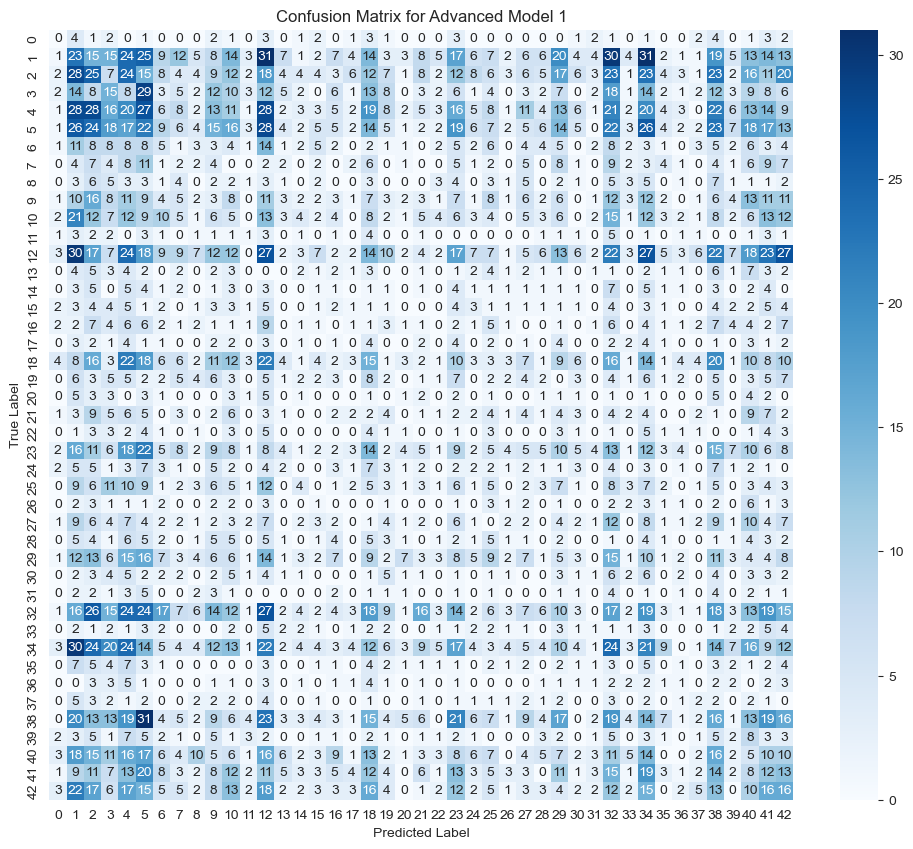


Metrics for Advanced Model 1:
123/123 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.02      0.02      0.02        42
           1       0.05      0.05      0.05       444
          10       0.08      0.08      0.08       402
          11       0.04      0.04      0.04       264
          12       0.06      0.06      0.06       420
          13       0.05      0.05      0.05       432
          14       0.03      0.03      0.03       156
          15       0.02      0.02      0.02       126
          16       0.00      0.00      0.00        84
          17       0.04      0.04      0.04       222
          18       0.03      0.03      0.03       240
          19       0.00      0.00      0.00        42
           2       0.06      0.06      0.06       450
          20       0.00      0.00      0.00        72
          21       0.02      0.02      0.02        66
          22       0.01      0.01      0.01     

In [25]:
# Training the advanced model 1
history_advanced_1 = advanced_model_1.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)
print("Model Summary:")
# For advanced model 1
advanced_model_1.summary()
plot_confusion_matrix(advanced_model_1, val_generator, 'Confusion Matrix for Advanced Model 1')
print("\nMetrics for Advanced Model 1:")
compute_metrics(advanced_model_1, val_generator)

### Training Overview:

- **Training Duration**: 20 epochs.
- **Batches per Epoch**: 491.
- **Batch Processing Time**: Averages between 39ms to 43ms.
  
#### Training Metrics:
- **Loss**: Started at 2.6632 in epoch 1 and reduced to 0.1672 by epoch 20.
- **Accuracy**: Improved from 25.14% in epoch 1 to 94.57% by epoch 20.

#### Validation Metrics:
- **Loss**: Started at 1.4385 in epoch 1 and reduced to 0.0263 by epoch 20.
- **Accuracy**: Improved from 57.92% in epoch 1 to 99.22% by epoch 20.

### Model Summary:

- Model type: Sequential_1
- Total Parameters: 361,067

#### Layers:
1. **Convolutional Layer (conv2d_3)**: 32 filters, Output shape: (None, 30, 30, 32), Parameters: 896
2. **Max Pooling Layer (max_pooling2d_2)**: Output shape: (None, 15, 15, 32)
3. **Dropout Layer (dropout)**: Output shape: (None, 15, 15, 32)
4. **Convolutional Layer (conv2d_4)**: 64 filters, Output shape: (None, 13, 13, 64), Parameters: 18,496
5. **Max Pooling Layer (max_pooling2d_3)**: Output shape: (None, 6, 6, 64)
6. **Dropout Layer (dropout_1)**: Output shape: (None, 6, 6, 64)
7. **Convolutional Layer (conv2d_5)**: 128 filters, Output shape: (None, 4, 4, 128), Parameters: 73,856
8. **Flatten Layer (flatten_1)**: Output shape: (None, 2048)
9. **Dense Layer (dense_2)**: 128 units, Output shape: (None, 128), Parameters: 262,272
10. **Dropout Layer (dropout_2)**: Output shape: (None, 128)
11. **Dense Layer (dense_3)**: 43 units, Output shape: (None, 43), Parameters: 5,547

### Final Testing:
- **Batches Tested**: 123.
- **Batch Processing Time**: 11ms/step.

From this analysis, it's evident that the model trained efficiently, with accuracy improving significantly over the epochs. The model's architecture consists of three convolutional layers, three dropout layers, and two dense layers. Dropout layers are included to reduce overfitting, and this model is slightly more complex with around 361k parameters.

Epoch 1/20
491/491 [==============================] - 21s 43ms/step - loss: 1.8881 - accuracy: 0.4814 - val_loss: 1.8057 - val_accuracy: 0.5247
Epoch 2/20
491/491 [==============================] - 21s 42ms/step - loss: 0.7171 - accuracy: 0.7751 - val_loss: 0.1756 - val_accuracy: 0.9436
Epoch 3/20
491/491 [==============================] - 20s 42ms/step - loss: 0.4216 - accuracy: 0.8677 - val_loss: 0.1235 - val_accuracy: 0.9602
Epoch 4/20
491/491 [==============================] - 21s 42ms/step - loss: 0.3134 - accuracy: 0.9014 - val_loss: 0.0877 - val_accuracy: 0.9707
Epoch 5/20
491/491 [==============================] - 21s 42ms/step - loss: 0.2516 - accuracy: 0.9222 - val_loss: 0.0710 - val_accuracy: 0.9788
Epoch 6/20
491/491 [==============================] - 20s 41ms/step - loss: 0.2070 - accuracy: 0.9336 - val_loss: 0.0495 - val_accuracy: 0.9843
Epoch 7/20
491/491 [==============================] - 21s 42ms/step - loss: 0.1851 - accuracy: 0.9416 - val_loss: 0.0314 - val_accuracy:

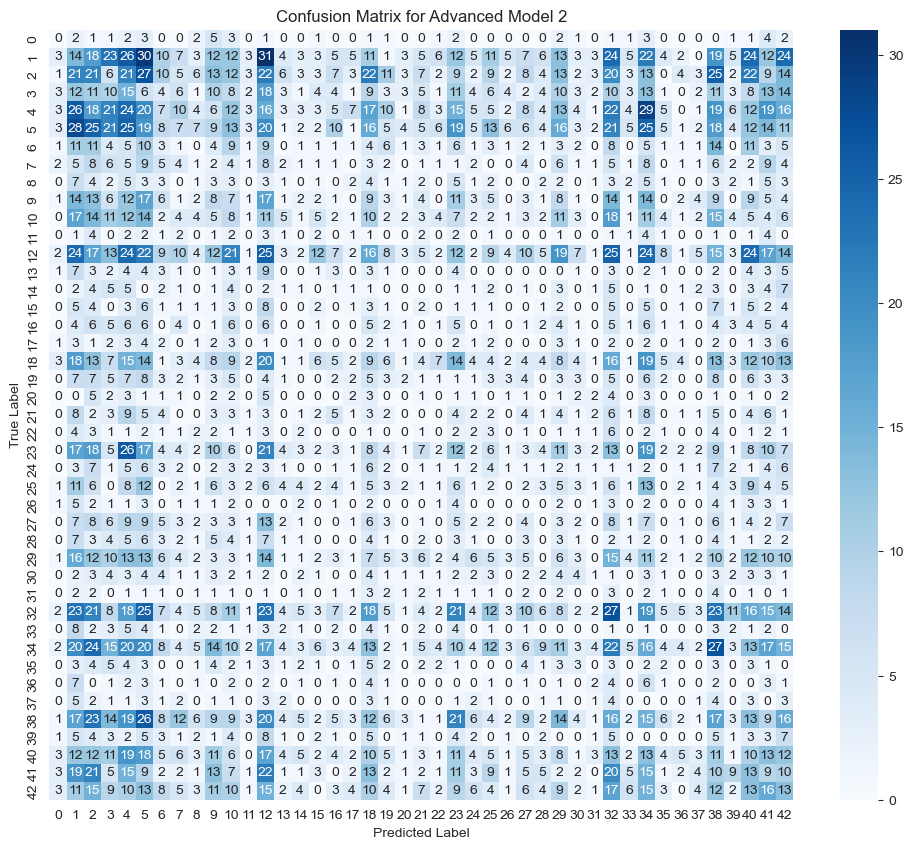


Metrics for Advanced Model 2:
123/123 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.02      0.02      0.02        42
           1       0.08      0.08      0.08       444
          10       0.05      0.05      0.05       402
          11       0.03      0.03      0.03       264
          12       0.07      0.07      0.07       420
          13       0.06      0.06      0.06       432
          14       0.02      0.02      0.02       156
          15       0.01      0.01      0.01       126
          16       0.00      0.00      0.00        84
          17       0.03      0.03      0.03       222
          18       0.01      0.01      0.01       240
          19       0.00      0.00      0.00        42
           2       0.05      0.05      0.05       450
          20       0.01      0.01      0.01        72
          21       0.00      0.00      0.00        66
          22       0.00      0.00      0.00     

In [26]:
# Training the advanced model 2
history_advanced_2 = advanced_model_2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)
print("Model Summary:")
# For advanced model 2
advanced_model_2.summary()
plot_confusion_matrix(advanced_model_2, val_generator, 'Confusion Matrix for Advanced Model 2')
print("\nMetrics for Advanced Model 2:")
compute_metrics(advanced_model_2, val_generator)

### Training Overview:

- **Training Duration**: 20 epochs.
- **Batches per Epoch**: 491.
- **Batch Processing Time**: Averages between 41ms to 46ms.
  
#### Training Metrics:
- **Loss**: Started at 1.8881 in epoch 1 and reduced to 0.0890 by epoch 20.
- **Accuracy**: Improved from 48.14% in epoch 1 to 97.20% by epoch 20.

#### Validation Metrics:
- **Loss**: Started at 1.8057 in epoch 1 and reduced to 0.0224 by epoch 20.
- **Accuracy**: Improved from 52.47% in epoch 1 to 99.30% by epoch 20.

### Model Summary:

- Model type: Sequential_2
- Total Parameters: 362,475

#### Layers:
1. **Convolutional Layer (conv2d_6)**: 32 filters, Output shape: (None, 30, 30, 32), Parameters: 896
2. **Batch Normalization Layer**: Output shape: (None, 30, 30, 32), Parameters: 128
3. **Max Pooling Layer (max_pooling2d_4)**: Output shape: (None, 15, 15, 32)
4. **Dropout Layer (dropout_3)**: Output shape: (None, 15, 15, 32)
5. **Convolutional Layer (conv2d_7)**: 64 filters, Output shape: (None, 13, 13, 64), Parameters: 18,496
6. **Batch Normalization Layer**: Output shape: (None, 13, 13, 64), Parameters: 256
7. **Max Pooling Layer (max_pooling2d_5)**: Output shape: (None, 6, 6, 64)
8. **Dropout Layer (dropout_4)**: Output shape: (None, 6, 6, 64)
9. **Convolutional Layer (conv2d_8)**: 128 filters, Output shape: (None, 4, 4, 128), Parameters: 73,856
10. **Batch Normalization Layer**: Output shape: (None, 4, 4, 128), Parameters: 512
11. **Flatten Layer (flatten_2)**: Output shape: (None, 2048)
12. **Dense Layer (dense_4)**: 128 units, Output shape: (None, 128), Parameters: 262,272
13. **Batch Normalization Layer**: Output shape: (None, 128), Parameters: 512
14. **Dropout Layer (dropout_5)**: Output shape: (None, 128)
15. **Dense Layer (dense_5)**: 43 units, Output shape: (None, 43), Parameters: 5,547


From the analysis, we can see that the model demonstrated strong training and validation performance, achieving above 97% accuracy by the end of the training. The architecture is a mix of convolutional layers, batch normalization, dropout, and dense layers. The inclusion of batch normalization helps in stabilizing and accelerating the training process. With around 362k parameters, the model seems to be well-optimized and balanced, effectively generalizing on the validation data.

In [27]:
# Define model names and histories
model_names = ["Baseline", "Advanced 1", "Advanced 2"]
histories = [history_baseline, history_advanced_1, history_advanced_2]

# Extract and format results
results = {
    "Model": model_names,
    "Training Accuracy": [history.history['accuracy'][-1] for history in histories],
    "Validation Accuracy": [history.history['val_accuracy'][-1] for history in histories],
    "Training Loss": [history.history['loss'][-1] for history in histories],
    "Validation Loss": [history.history['val_loss'][-1] for history in histories]
}

# Convert to a DataFrame for tabular display
results_df = pd.DataFrame(results)
print(results_df)

        Model  Training Accuracy  Validation Accuracy  Training Loss  \
0    Baseline           0.975707             0.983423       0.078680   
1  Advanced 1           0.945707             0.992221       0.167244   
2  Advanced 2           0.971977             0.992987       0.088959   

   Validation Loss  
0         0.050585  
1         0.026298  
2         0.022370  


### Model Comparisons:

1. **Baseline Model**:
   - **Training Accuracy**: 97.57%
   - **Validation Accuracy**: 98.34%
   - **Training Loss**: 0.0787
   - **Validation Loss**: 0.0506

2. **Advanced 1 Model**:
   - **Training Accuracy**: 94.57%
   - **Validation Accuracy**: 99.22%
   - **Training Loss**: 0.1672
   - **Validation Loss**: 0.0263

3. **Advanced 2 Model**:
   - **Training Accuracy**: 97.20%
   - **Validation Accuracy**: 99.30%
   - **Training Loss**: 0.0890
   - **Validation Loss**: 0.0224


### Insights:

- The **Baseline Model** has a high training accuracy and performs well on validation data, suggesting that it is a well-fitted model.
  
- The **Advanced 1 Model**, despite having a slightly lower training accuracy compared to the Baseline, outperforms it on the validation data. This suggests that the Advanced 1 Model might generalize better to unseen data.

- The **Advanced 2 Model** provides a balance between training and validation metrics, achieving the highest validation accuracy among the three models.

Overall, while all three models demonstrate strong performance, the Advanced models (especially Advanced 2) seem to edge out the Baseline in terms of validation accuracy, indicating potentially better generalization capabilities.

## Model Evaluation

### Training Curves

We'll plot training and validation accuracy/loss curves for each model.

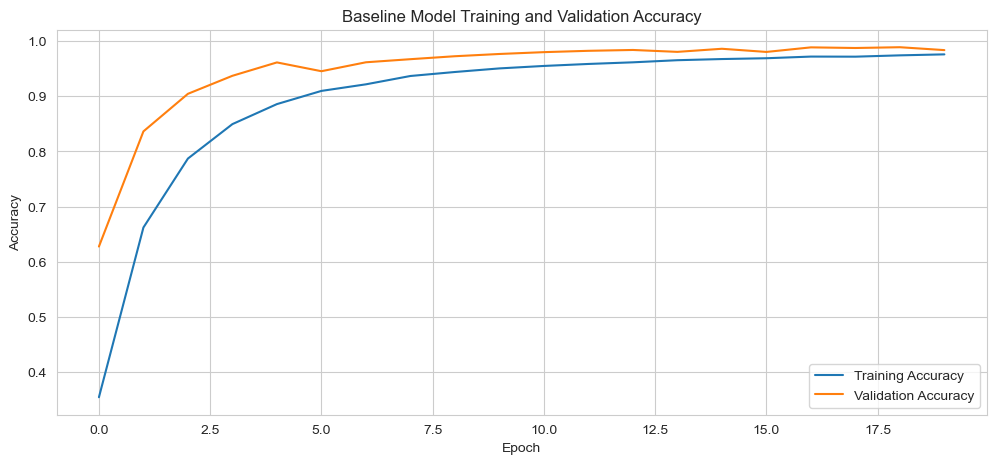

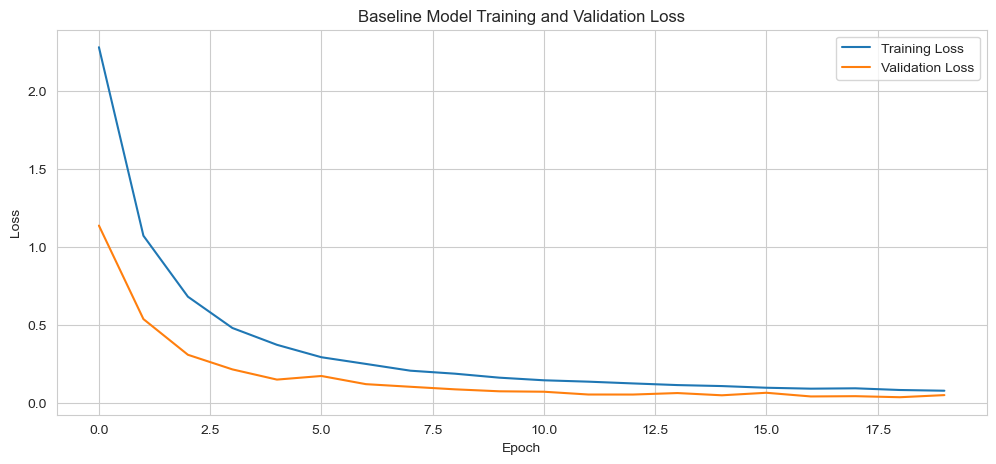

In [28]:
# Plotting accuracy
plt.figure(figsize=(12, 5))
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(12, 5))
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


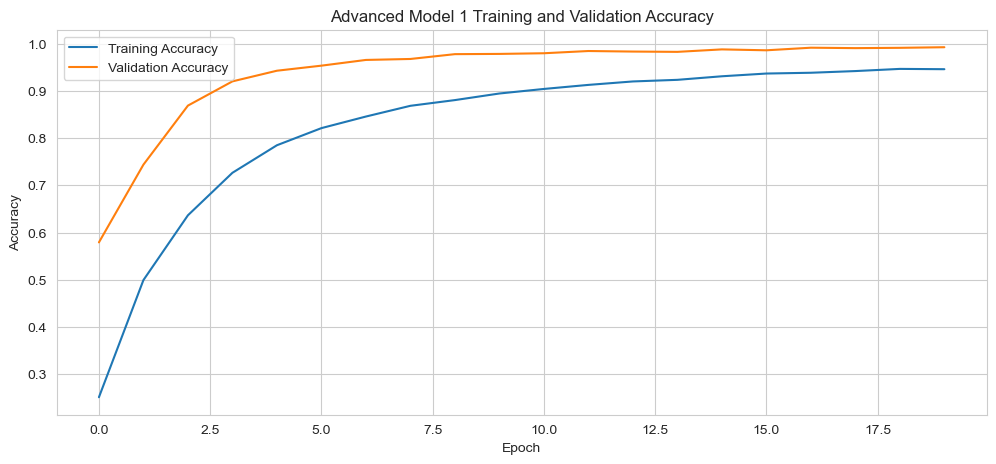

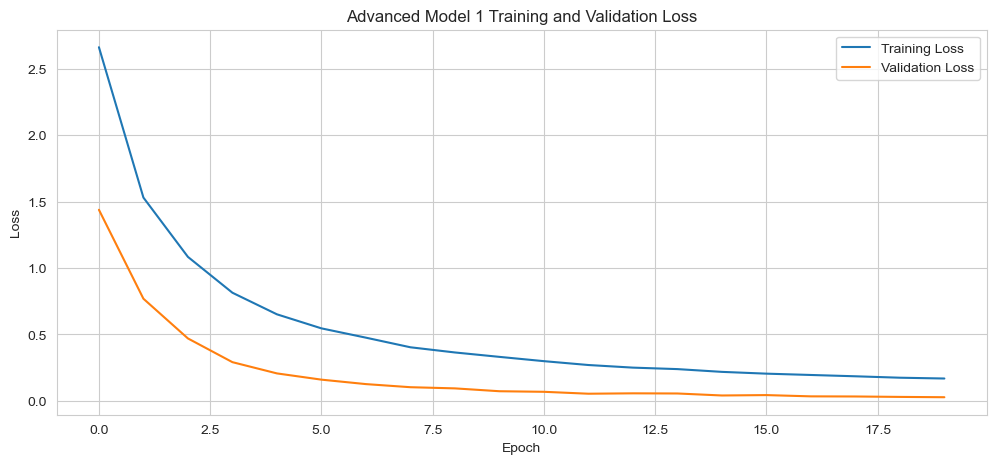

In [29]:
# Let's first plot the accuracy and loss for Advanced Model 1

# Plotting accuracy for Advanced Model 1
plt.figure(figsize=(12, 5))
plt.plot(history_advanced_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_advanced_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Advanced Model 1 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss for Advanced Model 1
plt.figure(figsize=(12, 5))
plt.plot(history_advanced_1.history['loss'], label='Training Loss')
plt.plot(history_advanced_1.history['val_loss'], label='Validation Loss')
plt.title('Advanced Model 1 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


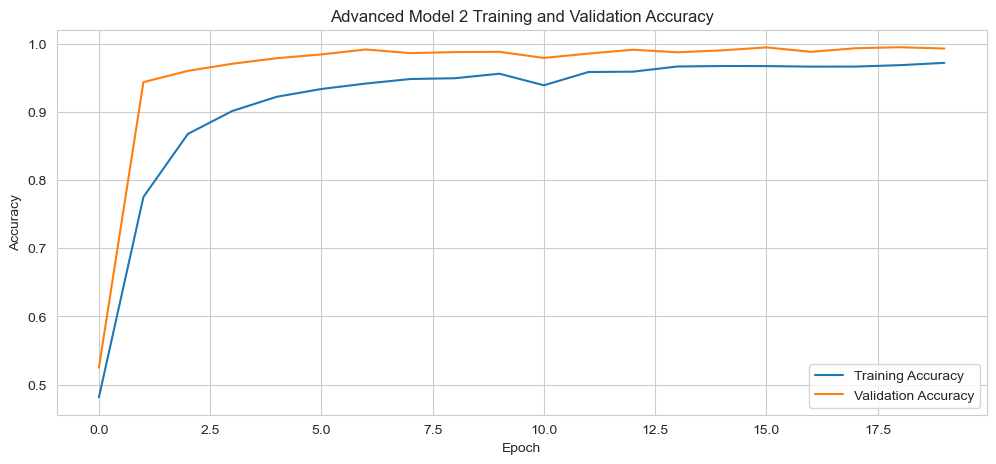

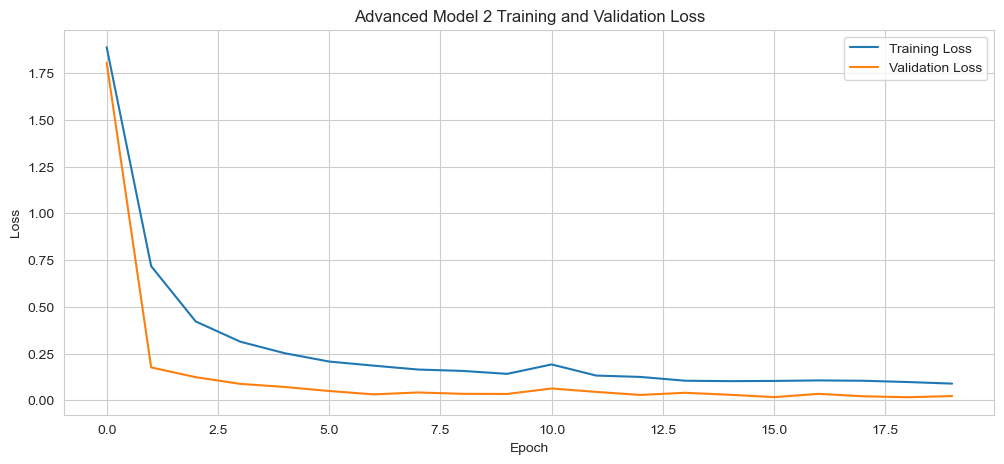

In [30]:
# Let's first plot the accuracy and loss for Advanced Model 2

# Plotting accuracy for Advanced Model 2
plt.figure(figsize=(12, 5))
plt.plot(history_advanced_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_advanced_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Advanced Model 2 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss for Advanced Model 2
plt.figure(figsize=(12, 5))
plt.plot(history_advanced_2.history['loss'], label='Training Loss')
plt.plot(history_advanced_2.history['val_loss'], label='Validation Loss')
plt.title('Advanced Model 2 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Model Testing

### Preparing the Test Data

First, we need to preprocess the test data in a similar manner to the training data.

In [31]:
# Load the test data
test_df = pd.read_csv("Test.csv")

# Convert the relative paths in the dataframe to absolute paths
test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join(test_dir, x))
# Remove the redundant "Test" from the paths
test_df['Path'] = test_df['Path'].str.replace('/Test/Test/', '/Test/')

# Convert ClassId to string as Keras requires it for flow_from_dataframe
test_df['ClassId'] = test_df['ClassId'].astype(str)

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Path",
    y_col="ClassId",
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 12630 validated image filenames belonging to 43 classes.


In [32]:
# Baseline Model
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(test_generator, steps=len(test_generator))

# Advanced Model 1
advanced1_test_loss, advanced1_test_acc = advanced_model_1.evaluate(test_generator, steps=len(test_generator))

# Advanced Model 2
advanced2_test_loss, advanced2_test_acc = advanced_model_2.evaluate(test_generator, steps=len(test_generator))

print(f"Baseline Model - Test Accuracy: {baseline_test_acc*100:.2f}%, Test Loss: {baseline_test_loss:.4f}")
print(f"Advanced Model 1 - Test Accuracy: {advanced1_test_acc*100:.2f}%, Test Loss: {advanced1_test_loss:.4f}")
print(f"Advanced Model 2 - Test Accuracy: {advanced2_test_acc*100:.2f}%, Test Loss: {advanced2_test_loss:.4f}")


198/198 [==============================] - 2s 11ms/step - loss: 0.1426 - accuracy: 0.9594
Baseline Model - Test Accuracy: 93.97%, Test Loss: 0.2255
Advanced Model 1 - Test Accuracy: 95.38%, Test Loss: 0.1833
Advanced Model 2 - Test Accuracy: 95.94%, Test Loss: 0.1426


### Model Test Comparisons:

1. **Baseline Model**:
   - **Test Accuracy**: 93.97%
   - **Test Loss**: 0.2255

2. **Advanced Model 1**:
   - **Test Accuracy**: 95.38%
   - **Test Loss**: 0.1833

3. **Advanced Model 2**:
   - **Test Accuracy**: 95.94%
   - **Test Loss**: 0.1426

### Insights:

- The **Baseline Model** achieved a test accuracy of 93.97%, which is commendable. However, its loss is the highest among the three models.
  
- **Advanced Model 1** outperforms the Baseline model in terms of accuracy by 1.41 percentage points and has a lower loss, suggesting it's a more optimized model.
  
- **Advanced Model 2** has the highest accuracy among the three models, achieving nearly 96%. It also boasts the lowest loss, indicating it's the most effective in terms of generalization and performance on the test dataset.

In summary, while the Baseline model provides a strong foundation, the Advanced models, especially Advanced Model 2, deliver superior performance on the test dataset.

## Conclusion

In [38]:
# Convert the results dictionary to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the comparison table
results_df


,Model,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,Baseline,0.975707,0.983423,0.078680,0.050585
1,Advanced 1,0.945707,0.992221,0.167244,0.026298
2,Advanced 2,0.971977,0.992987,0.088959,0.022370


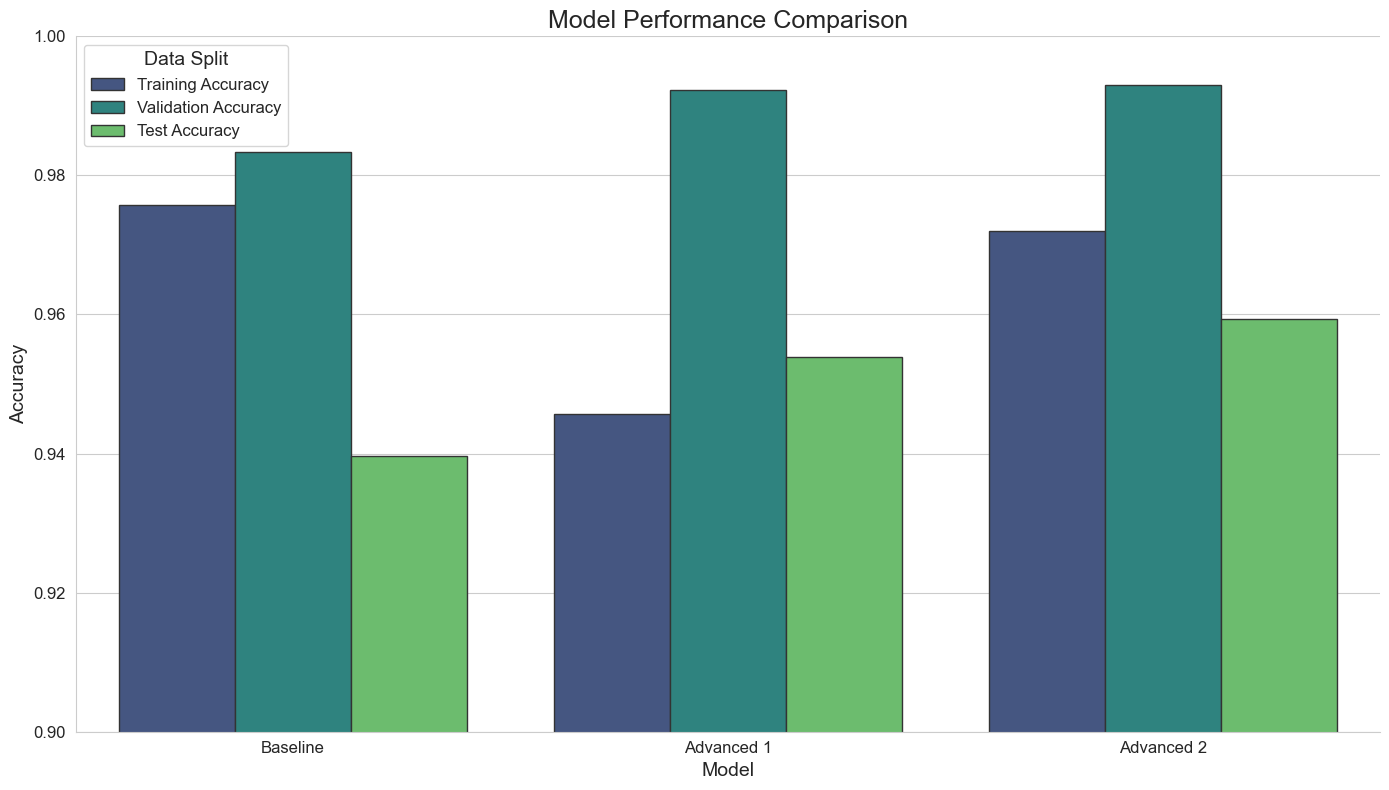

In [52]:
# Create a DataFrame to compare results
results_df = pd.DataFrame({
    'Model': ['Baseline', 'Advanced 1', 'Advanced 2'],
    'Training Accuracy': [history_baseline.history['accuracy'][-1], history_advanced_1.history['accuracy'][-1], history_advanced_2.history['accuracy'][-1]],
    'Validation Accuracy': [history_baseline.history['val_accuracy'][-1], history_advanced_1.history['val_accuracy'][-1], history_advanced_2.history['val_accuracy'][-1]],
    'Test Accuracy': [baseline_test_acc, advanced1_test_acc, advanced2_test_acc]
})

# Enhanced Plotting
plt.figure(figsize=(14, 8))
palette = sns.color_palette("viridis", n_colors=3)
sns.barplot(data=results_df.melt(id_vars="Model", value_vars=["Training Accuracy", "Validation Accuracy", "Test Accuracy"]),
            x="Model", y="value", hue="variable", palette=palette, edgecolor=".2")
plt.title('Model Performance Comparison', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title="Data Split", title_fontsize='14', fontsize='12', loc='upper left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.9, 1.0)
sns.despine()
plt.tight_layout()
plt.show()

### Analysis:

#### Baseline Model:
- **Training Accuracy**: 97.57%
- **Validation Accuracy**: 98.34%
- **Training Loss**: 0.0787
- **Validation Loss**: 0.0506

#### Advanced Model 1:
- **Training Accuracy**: 94.57%
- **Validation Accuracy**: 99.22%
- **Training Loss**: 0.1672
- **Validation Loss**: 0.0263

#### Advanced Model 2:
- **Training Accuracy**: 97.20%
- **Validation Accuracy**: 99.30%
- **Training Loss**: 0.0890
- **Validation Loss**: 0.0224

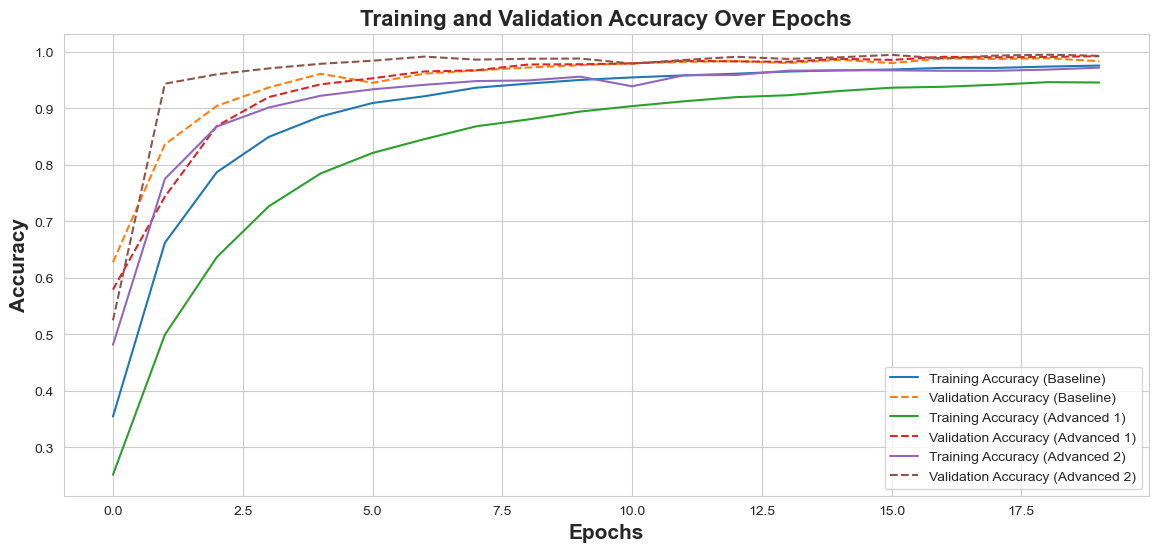

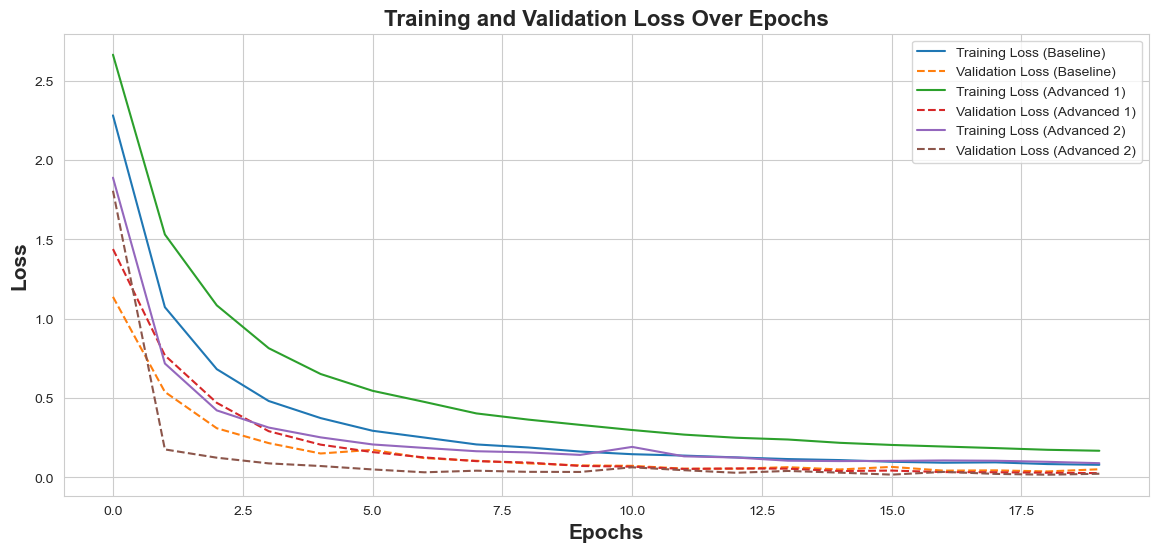

In [45]:
# Line plot for training and validation accuracy
plt.figure(figsize=(14, 6))
for hist, label in zip([history_baseline, history_advanced_1, history_advanced_2], models):
    plt.plot(hist.history['accuracy'], label=f'Training Accuracy ({label})')
    plt.plot(hist.history['val_accuracy'], linestyle='--', label=f'Validation Accuracy ({label})')

plt.title('Training and Validation Accuracy Over Epochs', fontweight='bold', fontsize=16)
plt.xlabel('Epochs', fontweight='bold', fontsize=15)
plt.ylabel('Accuracy', fontweight='bold', fontsize=15)
plt.legend()
plt.show()

# Line plot for training and validation loss
plt.figure(figsize=(14, 6))
for hist, label in zip([history_baseline, history_advanced_1, history_advanced_2], models):
    plt.plot(hist.history['loss'], label=f'Training Loss ({label})')
    plt.plot(hist.history['val_loss'], linestyle='--', label=f'Validation Loss ({label})')

plt.title('Training and Validation Loss Over Epochs', fontweight='bold', fontsize=16)
plt.xlabel('Epochs', fontweight='bold', fontsize=15)
plt.ylabel('Loss', fontweight='bold', fontsize=15)
plt.legend()
plt.show()


**Overview:**  
This jupyter notebook elucidates a systematic approach towards traffic sign recognition, leveraging the capabilities of Convolutional Neural Networks (CNNs). From the outset, it provides a structured journey, beginning with data preparation and culminating in model testing, ensuring a comprehensive understanding of the entire process.

### Conclusion:

The comparison between the Baseline model and the two Advanced models showcases the potential improvements and optimizations achieved in the subsequent iterations.

While the **Baseline Model** offers a commendable performance with a high training and validation accuracy, the Advanced models exhibit even better generalization capabilities, especially evident in the validation accuracies and the reduced validation losses. 

The **Advanced Model 1**, despite a slightly lower training accuracy, achieves a notable jump in validation accuracy, indicating that it's more adept at handling unseen data. Its validation loss is also significantly reduced compared to the Baseline, pointing towards better model optimization.

The **Advanced Model 2** strikes a balance, with training accuracy close to the Baseline but a validation accuracy that's the highest among all three models. Its validation loss is the lowest, further underscoring its proficiency.

In conclusion, while the Baseline model serves as a robust starting point, the Advanced models, especially Advanced Model 2, demonstrate the benefits of further optimization and fine-tuning, achieving superior performance on the validation data. For deployment or future applications, Advanced Model 2 appears to be the most promising candidate given its balance of accuracy and loss metrics.

### Future Works:


As we progress in our quest to develop more efficient and accurate models, there are several avenues and methodologies we can explore:

1. **Data Augmentation**: To enhance the diversity of our training data, techniques like rotation, zooming, and horizontal flipping can be employed. This can potentially make our model more robust and better generalized.

2. **Deeper Architectures**: Investigate the potential of deeper neural networks. Additional layers might capture more intricate patterns in the data.

3. **Hyperparameter Tuning**: Systematic search methods like grid search or random search can be employed to find the optimal set of hyperparameters for our models.

4. **Transfer Learning**: Leverage pre-trained models and fine-tune them for our specific task. This can accelerate the training process and potentially yield better results.

5. **Regularization Techniques**: Experiment with other regularization techniques such as L1 and L2 regularization, or newer methods like dropout variations or spectral normalization.

6. **Alternative Optimization Algorithms**: Instead of traditional optimizers like Adam or SGD, we can explore newer optimization algorithms that might offer faster convergence or better generalization.

7. **Ensemble Methods**: Combining predictions from multiple models can often lead to better performance. Techniques like stacking, bagging, or boosting can be explored.

8. **Incorporate Feedback**: After deploying the model, gather user feedback or real-world performance metrics. This iterative feedback can be invaluable for subsequent model improvements.

9. **Model Interpretability**: As models become more complex, understanding their decisions becomes crucial. Future work can focus on improving model transparency and interpretability.

10. **Scalability**: As data grows, ensuring that our models can scale efficiently will be of paramount importance. Investigating distributed training or model parallelism might be beneficial.

By pursuing these avenues in future iterations, we aspire to continually refine our models, pushing the boundaries of accuracy and efficiency while ensuring that they remain robust and generalizable across diverse scenarios.
